In [32]:
! pip install statsmodels

     ---------------------------------------- 9.1/9.1 MB 3.1 MB/s eta 0:00:00
     -------------------------------------- 233.7/233.7 kB 2.9 MB/s eta 0:00:00


In [4]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import sklearn
from sklearn import tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor

## 1. Import dataset

In [5]:
#Import the CSV File from Kaggle, remove the last extra column(16) from the dataset, total 558836 rows

carprice = pd.read_csv("car_prices.csv")
carprice=carprice.drop(carprice.columns[16],axis=1)



C:\Users\ZHANGL6\AppData\Local\Temp\1\ipykernel_16100\3203063653.py:3: DtypeWarning: Columns (8,13,16) have mixed types. Specify dtype option on import or set low_memory=False.
  carprice = pd.read_csv("car_prices.csv")


## 2. Clean and process data


In [6]:
carprice = carprice.dropna()
carprice.head()

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,mmr,sellingprice,saledate
0,2015.0,Kia,Sorento,LX,SUV,automatic,5xyktca69fg566472,ca,5.0,16639.0,white,black,"kia motors america, inc",20500,21500.0,Tue Dec 16 2014 12:30:00 GMT-0800 (PST)
1,2015.0,Kia,Sorento,LX,SUV,automatic,5xyktca69fg561319,ca,5.0,9393.0,white,beige,"kia motors america, inc",20800,21500.0,Tue Dec 16 2014 12:30:00 GMT-0800 (PST)
2,2014.0,BMW,3 Series,328i SULEV,Sedan,automatic,wba3c1c51ek116351,ca,4.5,1331.0,gray,black,financial services remarketing (lease),31900,30000.0,Thu Jan 15 2015 04:30:00 GMT-0800 (PST)
3,2015.0,Volvo,S60,T5,Sedan,automatic,yv1612tb4f1310987,ca,4.1,14282.0,white,black,volvo na rep/world omni,27500,27750.0,Thu Jan 29 2015 04:30:00 GMT-0800 (PST)
4,2014.0,BMW,6 Series Gran Coupe,650i,Sedan,automatic,wba6b2c57ed129731,ca,4.3,2641.0,gray,black,financial services remarketing (lease),66000,67000.0,Thu Dec 18 2014 12:30:00 GMT-0800 (PST)


### 2.1 Get proper saledate value as datetime type


In [7]:

# Create a new column Sale_date to store the sale_date value
#Use saledate column as key, converted to numeric value. Becuase by looking at the data file, some rows has a number instead of date. Returning NaN means the value in that row is invalid
#Drop non-NaN (in this case keep all NaN) rows
#Drop column saledate as all is already stored in sale_date column
carprice_1=carprice
carprice_1['sale_date']=carprice_1['saledate']
carprice_1['saledate']=pd.to_numeric(carprice_1['saledate'],errors='coerce')
carprice_1=carprice_1.loc[pd.isna(carprice['saledate'])]
carprice_1=carprice_1.drop(columns='saledate')
carprice_1.head()


,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,mmr,sellingprice,sale_date
0,2015.0,Kia,Sorento,LX,SUV,automatic,5xyktca69fg566472,ca,5.0,16639.0,white,black,"kia motors america, inc",20500,21500.0,Tue Dec 16 2014 12:30:00 GMT-0800 (PST)
1,2015.0,Kia,Sorento,LX,SUV,automatic,5xyktca69fg561319,ca,5.0,9393.0,white,beige,"kia motors america, inc",20800,21500.0,Tue Dec 16 2014 12:30:00 GMT-0800 (PST)
2,2014.0,BMW,3 Series,328i SULEV,Sedan,automatic,wba3c1c51ek116351,ca,4.5,1331.0,gray,black,financial services remarketing (lease),31900,30000.0,Thu Jan 15 2015 04:30:00 GMT-0800 (PST)
3,2015.0,Volvo,S60,T5,Sedan,automatic,yv1612tb4f1310987,ca,4.1,14282.0,white,black,volvo na rep/world omni,27500,27750.0,Thu Jan 29 2015 04:30:00 GMT-0800 (PST)
4,2014.0,BMW,6 Series Gran Coupe,650i,Sedan,automatic,wba6b2c57ed129731,ca,4.3,2641.0,gray,black,financial services remarketing (lease),66000,67000.0,Thu Dec 18 2014 12:30:00 GMT-0800 (PST)


In [8]:
#Convert sale_date to type of datetime
#First- slice the last 15 char : -GMT-0800(PST)
#Second- convert using pd.to_datetime()
carprice_1['sale_date']=carprice_1['sale_date'].str.slice(0,-15,1)
carprice_1['sale_date']=pd.to_datetime(carprice_1['sale_date'],format='%a %b %d %Y %H:%M:%S')
carprice_1['sale_date'].head()

0   2014-12-16 12:30:00
1   2014-12-16 12:30:00
2   2015-01-15 04:30:00
3   2015-01-29 04:30:00
4   2014-12-18 12:30:00
Name: sale_date, dtype: datetime64[ns]

In [9]:
#Create new columns from sale_date to further detail ie. Day, month, year, weekday, hour
#Drop the original sale_date column

carprice_1['sale_weekday']=carprice_1['sale_date'].dt.day_name()
carprice_1['sale_year']=carprice_1['sale_date'].dt.year
carprice_1['sale_month']=carprice_1['sale_date'].dt.month_name()
carprice_1['sale_day']=carprice_1['sale_date'].dt.day
carprice_1['sale_time']=carprice_1['sale_date'].dt.hour
carprice_1=carprice_1.drop(columns=['sale_date'])
carprice_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 472334 entries, 0 to 558835
Data columns (total 20 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          472334 non-null  float64
 1   make          472334 non-null  object 
 2   model         472334 non-null  object 
 3   trim          472334 non-null  object 
 4   body          472334 non-null  object 
 5   transmission  472334 non-null  object 
 6   vin           472334 non-null  object 
 7   state         472334 non-null  object 
 8   condition     472334 non-null  object 
 9   odometer      472334 non-null  float64
 10  color         472334 non-null  object 
 11  interior      472334 non-null  object 
 12  seller        472334 non-null  object 
 13  mmr           472334 non-null  object 
 14  sellingprice  472334 non-null  float64
 15  sale_weekday  472334 non-null  object 
 16  sale_year     472334 non-null  int64  
 17  sale_month    472334 non-null  object 
 18  sale

### 2.2 Drop anomaly in Model column

In [10]:
#Drop rows that contain '-' at columen 'Model'
#Understanding condition(boolen) in dataframe/series--df[df['column']==1] will select rows that are True
carprice_2=carprice_1
carprice_2=carprice_2.drop(carprice_2[carprice_2['model'].str.contains('-Sep').astype(bool)].index)
carprice_2.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 471975 entries, 0 to 558835
Data columns (total 20 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          471975 non-null  float64
 1   make          471975 non-null  object 
 2   model         471975 non-null  object 
 3   trim          471975 non-null  object 
 4   body          471975 non-null  object 
 5   transmission  471975 non-null  object 
 6   vin           471975 non-null  object 
 7   state         471975 non-null  object 
 8   condition     471975 non-null  object 
 9   odometer      471975 non-null  float64
 10  color         471975 non-null  object 
 11  interior      471975 non-null  object 
 12  seller        471975 non-null  object 
 13  mmr           471975 non-null  object 
 14  sellingprice  471975 non-null  float64
 15  sale_weekday  471975 non-null  object 
 16  sale_year     471975 non-null  int64  
 17  sale_month    471975 non-null  object 
 18  sale

### 2.3 Drop anomaly in transmission



In [11]:
carprice_2=carprice_2.drop(carprice_2[carprice_2['transmission'].str.contains('Sedan').astype(bool)].index)
carprice_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 471975 entries, 0 to 558835
Data columns (total 20 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          471975 non-null  float64
 1   make          471975 non-null  object 
 2   model         471975 non-null  object 
 3   trim          471975 non-null  object 
 4   body          471975 non-null  object 
 5   transmission  471975 non-null  object 
 6   vin           471975 non-null  object 
 7   state         471975 non-null  object 
 8   condition     471975 non-null  object 
 9   odometer      471975 non-null  float64
 10  color         471975 non-null  object 
 11  interior      471975 non-null  object 
 12  seller        471975 non-null  object 
 13  mmr           471975 non-null  object 
 14  sellingprice  471975 non-null  float64
 15  sale_weekday  471975 non-null  object 
 16  sale_year     471975 non-null  int64  
 17  sale_month    471975 non-null  object 
 18  sale

### 2.3 Drop anomaly in transmission



In [12]:
#Check null value from the dataframe
#.sum() is the function that return the sum of the values over the requested axis

print(carprice_2.isnull().sum())

year            0
make            0
model           0
trim            0
body            0
transmission    0
vin             0
state           0
condition       0
odometer        0
color           0
interior        0
seller          0
mmr             0
sellingprice    0
sale_weekday    0
sale_year       0
sale_month      0
sale_day        0
sale_time       0
dtype: int64


In [13]:
#Make the 'condition' and 'mmr' data type from Object to float64 
#At the sametime remove the error from the dataset, clean up the csv file
#Link of Error Free dataset in the Data Source Cell
#Datatype of each variables show below

carprice_2['condition'] = carprice_2['condition'].astype(float)
carprice_2['mmr'] = carprice_2['mmr'].astype(float)
carprice_2.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 471975 entries, 0 to 558835
Data columns (total 20 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          471975 non-null  float64
 1   make          471975 non-null  object 
 2   model         471975 non-null  object 
 3   trim          471975 non-null  object 
 4   body          471975 non-null  object 
 5   transmission  471975 non-null  object 
 6   vin           471975 non-null  object 
 7   state         471975 non-null  object 
 8   condition     471975 non-null  float64
 9   odometer      471975 non-null  float64
 10  color         471975 non-null  object 
 11  interior      471975 non-null  object 
 12  seller        471975 non-null  object 
 13  mmr           471975 non-null  float64
 14  sellingprice  471975 non-null  float64
 15  sale_weekday  471975 non-null  object 
 16  sale_year     471975 non-null  int64  
 17  sale_month    471975 non-null  object 
 18  sale

## 3.Explore the dataset

### Plot the distrubution of the variables
, "mmr", "odometer", "sellingprice"
, "condition"

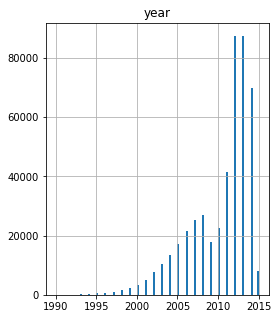

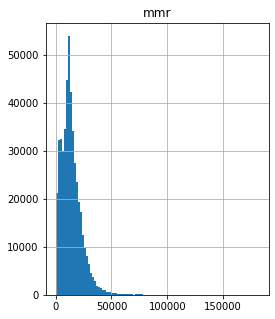

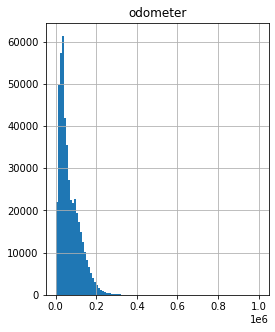

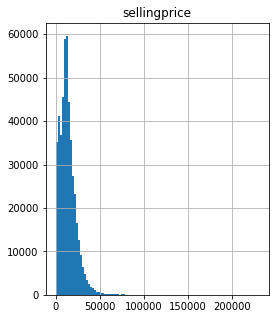

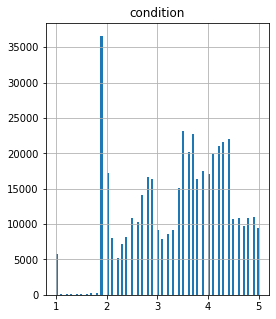

In [17]:
import matplotlib.pyplot as plt
carprice_2[["year"]].hist(bins=100, figsize=(4,5))
carprice_2[["mmr"]].hist(bins=100, figsize=(4,5))
carprice_2[["odometer"]].hist(bins=100, figsize=(4,5))
carprice_2[["sellingprice"]].hist(bins=100, figsize=(4,5))
carprice_2[["condition"]].hist(bins=100, figsize=(4,5))
plt.show()

In [18]:
# Check for skew in data
carprice_2.skew().sort_values(ascending=False)

C:\Users\ZHANGL6\AppData\Local\Temp\1\ipykernel_16100\1189907615.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  carprice_2.skew().sort_values(ascending=False)


mmr             2.050761
sellingprice    2.004289
odometer        1.916778
sale_time       1.570527
sale_day        0.042342
condition      -0.348141
year           -1.208259
sale_year      -3.150606
dtype: float64

In [21]:
carprice_2

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,mmr,sellingprice,sale_weekday,sale_year,sale_month,sale_day,sale_time
0,2015.0,Kia,Sorento,LX,SUV,automatic,5xyktca69fg566472,ca,5.0,16639.0,white,black,"kia motors america, inc",20500.0,21500.0,Tuesday,2014,December,16,12
1,2015.0,Kia,Sorento,LX,SUV,automatic,5xyktca69fg561319,ca,5.0,9393.0,white,beige,"kia motors america, inc",20800.0,21500.0,Tuesday,2014,December,16,12
2,2014.0,BMW,3 Series,328i SULEV,Sedan,automatic,wba3c1c51ek116351,ca,4.5,1331.0,gray,black,financial services remarketing (lease),31900.0,30000.0,Thursday,2015,January,15,4
3,2015.0,Volvo,S60,T5,Sedan,automatic,yv1612tb4f1310987,ca,4.1,14282.0,white,black,volvo na rep/world omni,27500.0,27750.0,Thursday,2015,January,29,4
4,2014.0,BMW,6 Series Gran Coupe,650i,Sedan,automatic,wba6b2c57ed129731,ca,4.3,2641.0,gray,black,financial services remarketing (lease),66000.0,67000.0,Thursday,2014,December,18,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
558830,2011.0,BMW,5 Series,528i,Sedan,automatic,wbafr1c53bc744672,fl,3.9,66403.0,white,brown,lauderdale imports ltd bmw pembrok pines,20300.0,22800.0,Tuesday,2015,July,7,6
558832,2012.0,Ram,2500,Power Wagon,Crew Cab,automatic,3c6td5et6cg112407,wa,5.0,54393.0,white,black,i -5 uhlmann rv,30200.0,30800.0,Wednesday,2015,July,8,9
558833,2012.0,BMW,X5,xDrive35d,SUV,automatic,5uxzw0c58cl668465,ca,4.8,50561.0,black,black,financial services remarketing (lease),29800.0,34000.0,Wednesday,2015,July,8,9
558834,2015.0,Nissan,Altima,2.5 S,sedan,automatic,1n4al3ap0fc216050,ga,3.8,16658.0,white,black,enterprise vehicle exchange / tra / rental / t...,15100.0,11100.0,Thursday,2015,July,9,6


In [52]:
#Selling price are right skewed, with out log of the selling price, model will have very large RMSE value

import numpy as np
carprice_Norm=carprice_2[['mmr','condition','sellingprice','odometer','sale_time','sale_day','year','sale_year']].apply(lambda x: np.log(x+1))

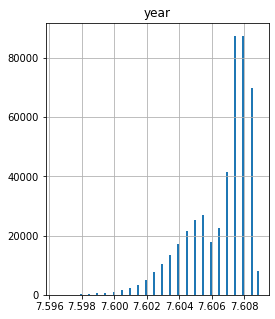

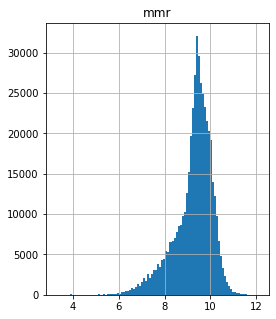

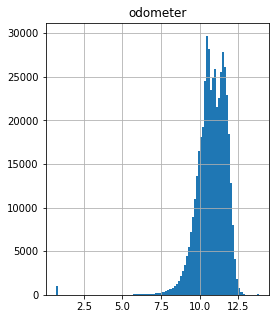

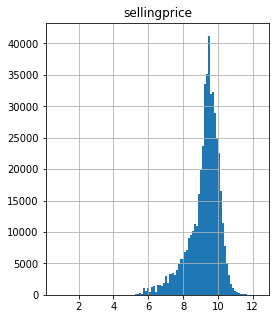

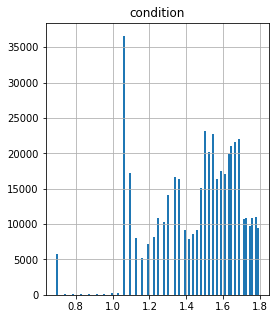

In [53]:
carprice_Norm[["year"]].hist(bins=100, figsize=(4,5))
carprice_Norm[["mmr"]].hist(bins=100, figsize=(4,5))
carprice_Norm[["odometer"]].hist(bins=100, figsize=(4,5))
carprice_Norm[["sellingprice"]].hist(bins=100, figsize=(4,5))
carprice_Norm[["condition"]].hist(bins=100, figsize=(4,5))
plt.show()

In [27]:
xlist = ["year", "condition", "odometer", "mmr"]
X = carprice_Norm[xlist]
y = carprice_Norm["sellingprice"]
carprice_Norm[xlist].describe()

,year,condition,odometer,mmr
count,471975.000000,471975.000000,471975.000000,471975.000000
mean,7.605995,1.186598,10.758991,9.266961
std,0.001903,0.316543,1.028696,0.830398
min,7.595890,0.000000,0.000000,3.218876
25%,7.604894,0.993252,10.244343,8.915969
50%,7.606885,1.280934,10.840345,9.421411
75%,7.607381,1.435085,11.477676,9.814656
max,7.608374,1.609438,13.815510,12.111762


### 3.1Divide the dataset into train and test sets

In [28]:
#Divide the dataset into 7/3 for training and testing dataset, set the random_state = 6 because we are group 6

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 6)
#x_train.head()

In [29]:
X_train.head()

,year,condition,odometer,mmr
60717,7.607878,1.098612,9.573455,10.485703
277799,7.606885,1.410987,10.287593,9.525151
72019,7.603898,0.693147,11.715156,9.277999
42938,7.606885,1.064711,10.697927,9.588777
3969,7.603898,1.193922,11.083741,8.411833


## 4.Linear regression model

In [30]:
from sklearn.linear_model import LinearRegression
carreg = LinearRegression()
carreg.fit(X_train, y_train)
carprice_3=carprice_2
# create a new column for the predicted car selling price
carprice_3["predict"] = carreg.predict(X)

In [33]:
import statsmodels.api as sm
import statsmodels.regression.linear_model as smf
results = smf.OLS(y_train,X_train).fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:           sellingprice   R-squared (uncentered):                   0.999
Model:                            OLS   Adj. R-squared (uncentered):              0.999
Method:                 Least Squares   F-statistic:                          1.459e+08
Date:                Mon, 29 Aug 2022   Prob (F-statistic):                        0.00
Time:                        17:11:50   Log-Likelihood:                          30564.
No. Observations:              330382   AIC:                                 -6.112e+04
Df Residuals:                  330378   BIC:                                 -6.108e+04
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [34]:
# Model Evaluation2: Calculate Root Mean Square Error (RMSE)
y_pred = carreg.predict(X_test)
reg_mse = mean_squared_error(y_pred, y_test)
reg_rmse = np.sqrt(reg_mse)
print('Liner Regression RMSE: %.4f' % reg_rmse)

Liner Regression RMSE: 0.2203


In [35]:
# Model Evaluation3: Calculate mean absolute error (MAE)
lin_mae = mean_absolute_error(y_pred, y_test)
print('Liner Regression MAE: %.4f' % lin_mae)

Liner Regression MAE: 0.1270


In [36]:
from sklearn.metrics import r2_score
print("R-squared", r2_score(y_test, y_pred))

R-squared 0.9384047618979845


## 5.Decision tree model

In [38]:
carregrtree = DecisionTreeRegressor(max_depth = 3)
carregrtree.fit(X_train, y_train)

carprice_3["tree_predict"] = carregrtree.predict(X)

In [39]:
y_pred_tree = carregrtree.predict(X_test)
tree_mse = mean_squared_error(y_pred_tree, y_test)
tree_rmse = np.sqrt(tree_mse)
print('Decision Tree RMSE: %.4f' % tree_rmse)

Decision Tree RMSE: 0.2836


In [40]:
# Model Evaluation3: Calculate mean absolute error (MAE)
tree_mae = mean_absolute_error(y_pred_tree, y_test)
print('Decision Tree MAE: %.4f' % tree_mae)

Decision Tree MAE: 0.1907


In [41]:
print("R-squared", r2_score(y_test, y_pred_tree))

R-squared 0.8978982172414692


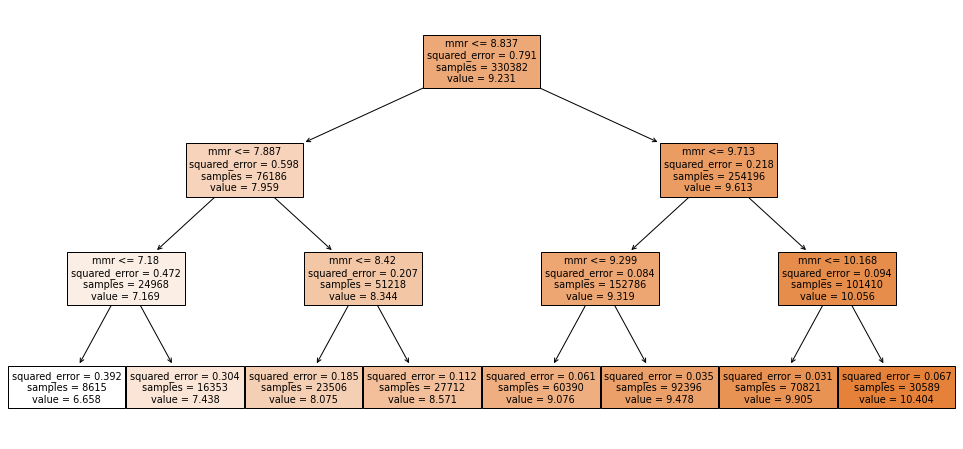

In [42]:
plt.figure(figsize=(17, 8))
tree.plot_tree(carregrtree, feature_names=xlist, filled=True)
plt.show()

## 6.Random forest model

In [43]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor(random_state=6)
forest_reg.fit(X_train, y_train)

y_pred_forest = forest_reg.predict(X_test)
forest_mse = mean_squared_error(y_pred_forest, y_test)
forest_rmse = np.sqrt(forest_mse)
print('Random Forest RMSE: %.4f' % forest_rmse)

forest_mae = mean_absolute_error(y_pred_forest, y_test)
print('Random Forest MAE: %.4f' % forest_mae)


Random Forest RMSE: 0.2138
Random Forest MAE: 0.1219


In [44]:
print("R-squared", r2_score(y_test, y_pred_forest))

R-squared 0.9419609830687115


## 7.Neural network model

In [45]:
# To improve the neural network performance, normalize the input variables

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train_nn = scaler.transform(X_train)
X_test_nn = scaler.transform(X_test)

In [47]:
from sklearn.neural_network import MLPRegressor
mlp = MLPRegressor(hidden_layer_sizes=(30,30,30), max_iter=2000)
mlp.fit(X_train_nn,y_train)

carprice_3["mlp_predict"] = mlp.predict(X)

C:\Users\ZHANGL6\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(


In [48]:
y_pred_mlp = mlp.predict(X_test_nn)
mlp_mse = mean_squared_error(y_pred_mlp, y_test)
mlp_rmse = np.sqrt(mlp_mse)
print('Neural Network RMSE: %.4f' % mlp_rmse)

Neural Network RMSE: 0.2024


In [49]:
# Model Evaluation3: Calculate mean absolute error (MAE)
mlp_mae = mean_absolute_error(y_pred_mlp, y_test)
print('Neural Network MAE: %.4f' % mlp_mae)

Neural Network MAE: 0.1130


In [50]:
print("R-squared", r2_score(y_test, y_pred_mlp))

R-squared 0.9479908824901712


## 8.Words Cloud

In [ ]:
import numpy as np
import pandas as pd
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt
%matplotlib inline


In [ ]:
df = pd.read_csv("data/car_prices.csv", na_values="?").dropna()
df.head()

# Not WORKING, PLEASE CHECK FILE FOR DETAILS !!!!!!!!!!!!!!!!!!!!!

In [ ]:
print("There are {} observations and {} features in this dataset. \n".format(df.shape[0],df.shape[1]))

print("There are {} Brands of car in this dataset such as {}... \n".format(len(df.make.unique()),
                                                                           ", ".join(df.make.unique()[0:5])))

print("There are {} model in this dataset such as {}... \n".format(len(df.model.unique()),
                                                                                      ", ".join(df.model.unique()[0:5])))